# Spatial Range

A common need is to search in the vicinity of a point and determine the intersection of two search areas. In this notebook, we introduce the concept of a *cover* which is a set of index values or intervals corresponding to an area that cover a region of interest. We construct two circular covers and determine their intersection, which is itself a cover. The intersection's index values (trixels) can be used to search for and combine STARE geolocated data.

In [1]:
import pystare as ps

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs

import numpy
import sys

In [2]:
# Helper functions.

def divert_stderr():
    sys.stderr = open('stderr.out','w')  
    return

def restore_stderr():
    sys.stderr.close()
    with open('stderr.out') as f:
        count = sum(1 for _ in f)
    if count > 0:
        print(count, 'warnings or errors encountered while stderr diverted. See stderr.out.')
    sys.stderr = sys.__stderr__
    return

In [3]:
# Some more helper functions for plotting & printing.

class figax_container(object):
    def __init__(self,figax):
        self.fig = figax[0]
        self.ax  = figax[1]
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options={'projection':ccrs.PlateCarree(),'transform':ccrs.Geodetic()}
        ,set_global=False
        ,show=True
        ):

    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        figax.ax.coastlines()
    else:
        ax = figax.ax
    
    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        divert_stderr()
        figax.ax.triplot(siv_triang,transform=plot_options['transform'])
        restore_stderr()
    
    if show:
        plt.show()
        
    return figax

def hex16(i):
    return "0x%016x"%i

km  = 1 # Unit of length
deg = 1 # Unit of angle


In [4]:
# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

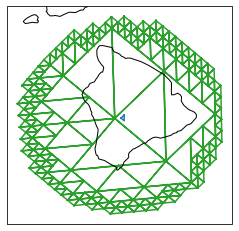

In [5]:
spatial_index_MaunaLoa = 0x2c2401f47797ec4b # Mauna Loa, ~ 5 km
finest_resolution = 10 # ~10km

# Make a cover centered on Mauna Loa
cover_MaunaLoa = ps.circular_cover_from(spatial_index_MaunaLoa,1*deg,finest_resolution)

figax = hello_plot([spatial_index_MaunaLoa],show=False) # Plot the mountain
figax = hello_plot(cover_MaunaLoa,figax) # Plot the cover


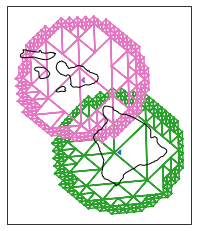

In [6]:
spatial_index_Haleakala = 0x2c326749360621cb # Haleakala ~ 5 km
finest_resolution = 10 # ~10km

# Make a cover centered on Haleakala
cover_Haleakala = ps.circular_cover_from(spatial_index_Haleakala,1*deg,finest_resolution)

figax = hello_plot([spatial_index_MaunaLoa],show=False)
figax = hello_plot(cover_MaunaLoa,figax,show=False)

figax = hello_plot([spatial_index_Haleakala],figax,show=False)
figax = hello_plot(cover_Haleakala,figax)


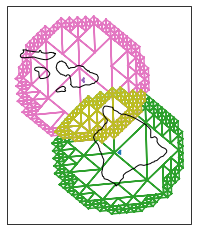

In [7]:
# Construct a spatial range for each cover
srange_MaunaLoa     = ps.srange(cover_MaunaLoa)
srange_Haleakala    = ps.srange(cover_Haleakala)

# Prepare a spatial range to hold the intersection
srange_intersection = ps.srange()

# Add the intersection
srange_intersection.add_intersect(srange_MaunaLoa,srange_Haleakala,False) # False disables a "compression" step

# Prepare an array to hold the indices associated with the intersection and copy into this array (a cover)
intersection_indices = numpy.zeros([srange_intersection.get_size_as_values()],dtype=numpy.int64)
srange_intersection.copy_values(intersection_indices)

# Plot Mauna Loa and the cover
figax = hello_plot([spatial_index_MaunaLoa],show=False)
figax = hello_plot(cover_MaunaLoa,figax,show=False) # green

# Plot Haleakala and the cover
figax = hello_plot([spatial_index_Haleakala],figax,show=False)
figax = hello_plot(cover_Haleakala,figax,show=False) # pink

# Plot the intersection cover (yellow)
figax = hello_plot(intersection_indices,figax) # yellow


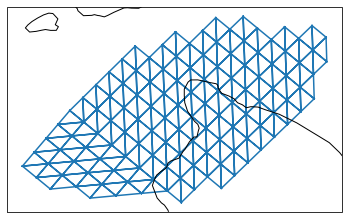

In [8]:
# Expand/coerce index values to resolution 10.
# The blue is the same area as the yellow cover above.
figax = hello_plot(ps.expand_intervals(intersection_indices,10)) 

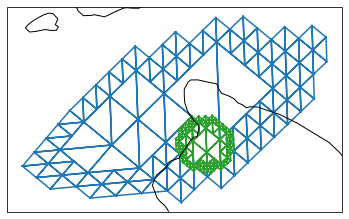

In [9]:
# Set Latitude, Longitude for Waikoloa Village, Hawaii
lat =   19.941389
lon = -155.792778

# Demonstrate a circular cover from a latitude, longitude pair.
cover_waikoloa = ps.to_circular_cover(lat,lon,0.125*deg,finest_resolution+2)

# figax = hello_plot(ps.expand_intervals(intersection_indices,10),show=False) # blue
figax = hello_plot(intersection_indices,show=False) # blue
figax = hello_plot(cover_waikoloa,figax) # green

# The intersection of these two can be performed as above.